<a href="https://colab.research.google.com/github/ASADUZZAMAN-HEROK/Football-Match-Prediction-with-Markov/blob/main/Football_Tournament_Prediction_(Copa_America_2021)_Using_Markov_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Football Tournament Prediction with Markov Chain (Copa America 2021)

\

###Team: Immutable 
\
Kawsar Ahmed\
ID: 170041021 \
Asaduzzaman Herok \
ID: 170041034 \
Shariar Nur Nahin \
ID: 170041049 \
Safayet Hossain Masum \
ID: 170041050

In [ ]:
############ Install required Libraries ###############

!pip install PyDTMC
!pip install --upgrade PyDTMC
!pip install -q kaggle
!pip install gdown

from IPython.display import clear_output 
clear_output()

In [ ]:
############# Import required Libraries ################

import numpy as np
import pandas as pd
import pydtmc
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
############ Upload kaggle API as kaggle.json #########

from google.colab import files
files.upload()


{}

In [ ]:
########### Download Copa America 2021 Dataset and Flags #########

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mcarujo/2021-copa-amrica

!gdown --id 1KRPGb_LWHaJdxw49uukb_U2gl9BphTVX
clear_output()

In [ ]:
########## Unzip to copa_america_2021_results.csv and Flags #######

!unzip /content/2021-copa-amrica.zip
!unzip /content/Flags.zip
clear_output()

In [ ]:
######### Load csv with Pandas #########################

copa2021 = pd.read_csv('/content/copa_america_2021_results.csv')
copa2021.columns

Index(['stage', 'date', 'pens', 'pens_home_score', 'pens_away_score',
       'team_name_home', 'team_name_away', 'team_home_score',
       'team_away_score', 'possession_home', 'possession_away',
       'total_shots_home', 'total_shots_away', 'shots_on_target_home',
       'shots_on_target_away', 'duels_won_home', 'duels_won_away',
       'events_list', 'lineup_home', 'lineup_away'],
      dtype='object')

In [ ]:
######## Extract only Relavant Columns ##################

needed_columns = ['stage','team_name_home','team_name_away','team_home_score','team_away_score','pens', 'pens_home_score','pens_away_score']
copa2021 = copa2021[needed_columns]

### Data Visualization

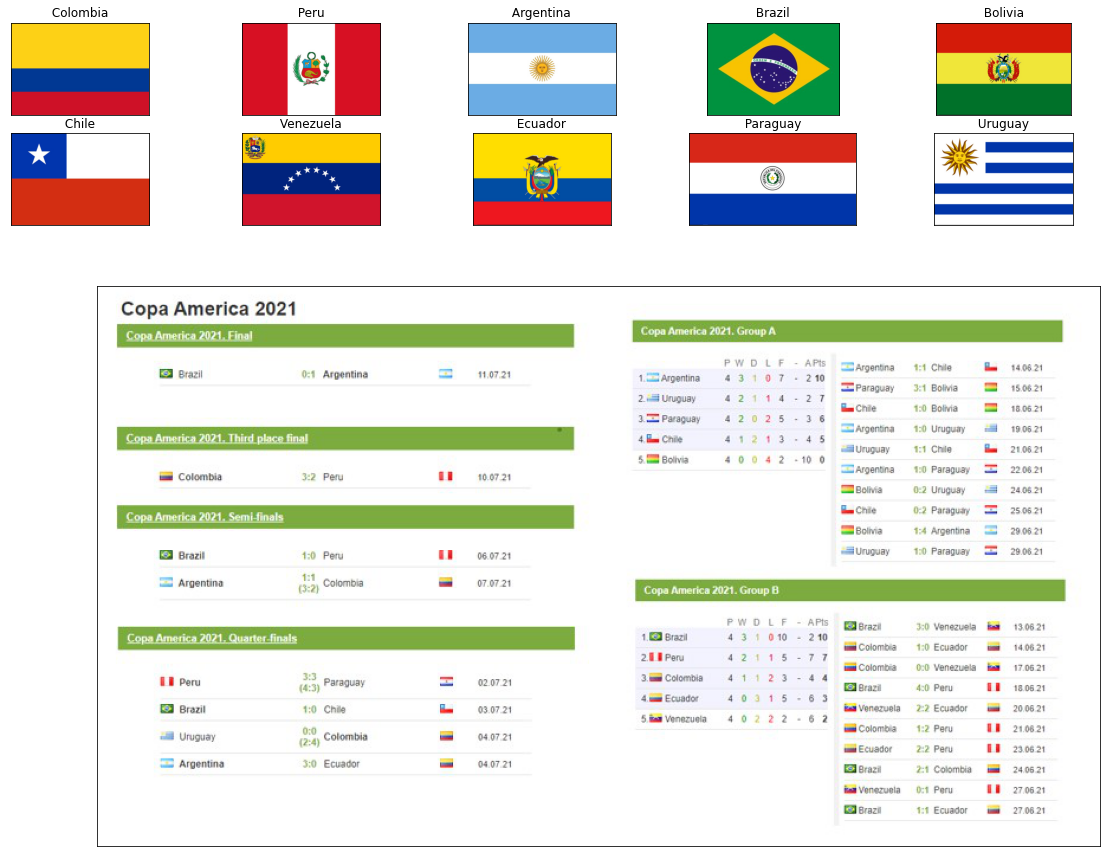

In [ ]:
####### Data Visualization ##############################
teams = set(list(copa2021['team_name_home'])+list(copa2021['team_name_away']))

fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(10,10)
idx = 1
for team in teams:
  fig.add_subplot(10,5,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+team.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(team)
  idx+=1
fig.add_subplot(gs[1:],xticks=[],yticks=[])
img = Image.open('/content/Flags/Copa America summary.jpg')
plt.imshow(img)


In [ ]:
copa2021['stage']           # Match Stages

0                        Final 
1        Match for third place 
2                  Semi-finals 
3                  Semi-finals 
4               Quarter-finals 
5               Quarter-finals 
6               Quarter-finals 
7               Quarter-finals 
8      Group stage: Matchday 5 
9      Group stage: Matchday 5 
10     Group stage: Matchday 5 
11     Group stage: Matchday 5 
12     Group stage: Matchday 4 
13     Group stage: Matchday 4 
14     Group stage: Matchday 4 
15     Group stage: Matchday 4 
16     Group stage: Matchday 3 
17     Group stage: Matchday 3 
18     Group stage: Matchday 3 
19     Group stage: Matchday 3 
20     Group stage: Matchday 2 
21     Group stage: Matchday 2 
22     Group stage: Matchday 2 
23     Group stage: Matchday 2 
24     Group stage: Matchday 1 
25     Group stage: Matchday 1 
26     Group stage: Matchday 1 
27     Group stage: Matchday 1 
Name: stage, dtype: object

### Quarter-Final Prediction

In [ ]:
########### Predict Quarter Final by Group Stage distribution ###################

def predict_Quarter_Final(matchdata):
  teams = list(set(list(matchdata['team_name_home'])+list(matchdata['team_name_away'])))
  goalMat = np.zeros((len(teams),len(teams)))
  #print(teams)
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']

    if stage.split()[0]!='Group':
      continue
    
    goalMat[teams.index(away_team)][teams.index(home_team)]=home_score
    goalMat[teams.index(home_team)][teams.index(away_team)]=away_score

    if penalty_shoot:
      goalMat[teams.index(away_team)][teams.index(home_team)]+=(int(home_penalty_score)/10)
      goalMat[teams.index(home_team)][teams.index(away_team)]+=(int(away_penalty_score)/10)
  
  goalMat/=np.sum(goalMat,axis=1)[:, np.newaxis]
  mc =    pydtmc.MarkovChain(goalMat,teams)
  #print(mc)
  steady_states = mc.steady_states[0]

  quater_final = dict()
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']
    if stage.split()[0] != 'Quarter-finals':
      continue
    
    pHome = steady_states[teams.index(home_team)]
    pAway = steady_states[teams.index(away_team)]

    homeOdds = 100*pHome/(pHome+pAway)
    awayOdds = 100*pAway/(pHome+pAway)

    homeActual = str(home_score) + '('+(home_penalty_score if penalty_shoot else '0')+')'
    awayActual = str(away_score) + '('+(away_penalty_score if penalty_shoot else '0')+')'

    quater_final[(home_team,away_team)]=((homeOdds, awayOdds),(homeActual,awayActual))

  return quater_final


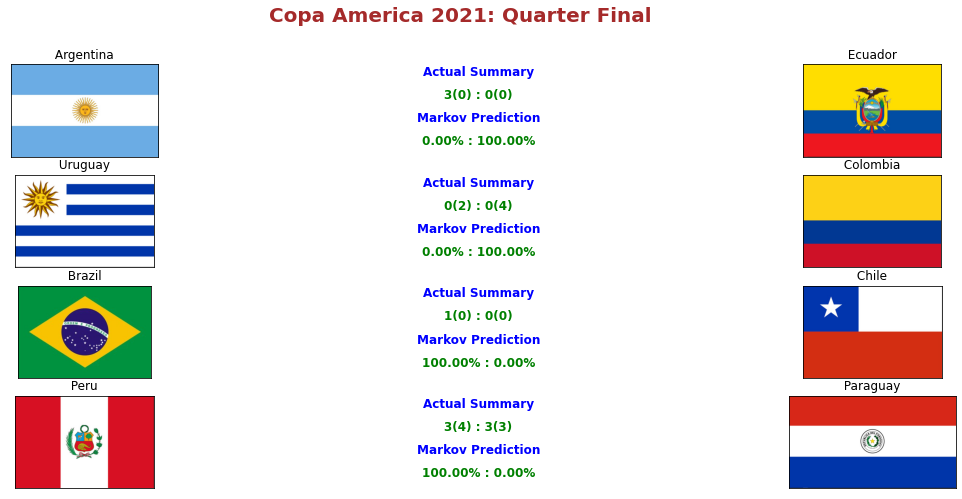

In [ ]:
Quarter_final = predict_Quarter_Final(copa2021)

fig = plt.figure(figsize=(20,20))
fig.suptitle("Copa America 2021: Quarter Final",y=0.92,fontsize=20,horizontalalignment='center',weight='bold', color ='Brown')
idx = 1

for k, v in Quarter_final.items():
  teamA, teamB = k
  oddsA, oddsB = v[0]
  scoreA, scoreB = v[1]
  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamA.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamA)
  idx+=1

  ax = fig.add_subplot(10,3,idx)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,4)
  ax.text(0.5,3.5,'Actual Summary',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,2.5,scoreA+' : '+scoreB,fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  ax.text(0.5,1.5,'Markov Prediction',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,0.5,f"{oddsA:0.2f}% : {oddsB:0.2f}%",fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  idx+=1

  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamB.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamB)
  idx+=1


### Semi-final Prediction

In [ ]:
########### Predict Semi-Final by Group Stage and Quarter-finals distribution ###################

def predict_Semi_Final(matchdata):
  teams = list(set(list(matchdata['team_name_home'])+list(matchdata['team_name_away'])))
  goalMat = np.zeros((len(teams),len(teams)))
  #print(teams)
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']

    if not (stage.split()[0]=='Group' or stage.split()[0]=='Quarter-finals'):
      continue
    
    goalMat[teams.index(away_team)][teams.index(home_team)]=home_score
    goalMat[teams.index(home_team)][teams.index(away_team)]=away_score

    if penalty_shoot:
      goalMat[teams.index(away_team)][teams.index(home_team)]+=(int(home_penalty_score)/10)
      goalMat[teams.index(home_team)][teams.index(away_team)]+=(int(away_penalty_score)/10)
  
  goalMat/=np.sum(goalMat,axis=1)[:, np.newaxis]
  #print(goalMat)
  mc =    pydtmc.MarkovChain(goalMat,teams)
  #print(mc)
  steady_states = mc.steady_states[0]
  #print(steady_states)

  quater_final = dict()
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']
    if stage.split()[0] != 'Semi-finals':
      continue
    
    pHome = steady_states[teams.index(home_team)]
    pAway = steady_states[teams.index(away_team)]

    homeOdds = 100*pHome/(pHome+pAway)
    awayOdds = 100*pAway/(pHome+pAway)

    homeActual = str(home_score) + '('+(home_penalty_score if penalty_shoot else '0')+')'
    awayActual = str(away_score) + '('+(away_penalty_score if penalty_shoot else '0')+')'

    quater_final[(home_team,away_team)]=((homeOdds, awayOdds),(homeActual,awayActual))

  return quater_final

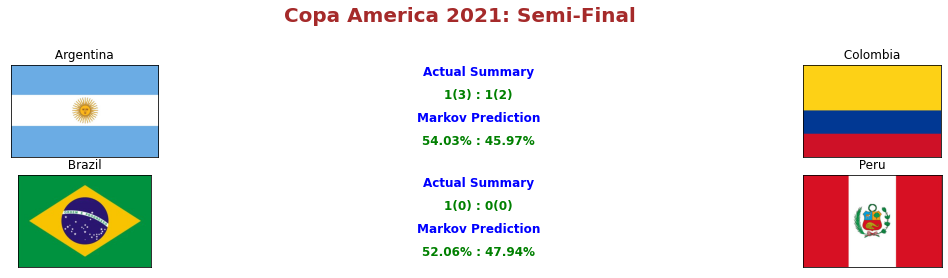

In [ ]:
Semi_final = predict_Semi_Final(copa2021)

fig = plt.figure(figsize=(20,20))
fig.suptitle("Copa America 2021: Semi-Final",x=0.5,y=0.92,fontsize=20,horizontalalignment='center',weight='bold', color ='Brown')
idx = 1

for k, v in Semi_final.items():
  teamA, teamB = k
  oddsA, oddsB = v[0]
  scoreA, scoreB = v[1]
  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamA.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamA)
  idx+=1

  ax = fig.add_subplot(10,3,idx)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,4)
  ax.text(0.5,3.5,'Actual Summary',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,2.5,scoreA+' : '+scoreB,fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  ax.text(0.5,1.5,'Markov Prediction',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,0.5,f"{oddsA:0.2f}% : {oddsB:0.2f}%",fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  idx+=1

  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamB.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamB)
  idx+=1


### Third Team Prediction

In [ ]:
########### Predict 3rd Team by Group Stage, Quarter-finals and Semi-finals distribution ###################

def predict_3rd_team(matchdata):
  teams = list(set(list(matchdata['team_name_home'])+list(matchdata['team_name_away'])))
  goalMat = np.zeros((len(teams),len(teams)))
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']

    if not (stage.split()[0]=='Group' or stage.split()[0]=='Quarter-finals' or stage.split()[0]=='Semi-finals'):
      continue
    
    goalMat[teams.index(away_team)][teams.index(home_team)]=home_score
    goalMat[teams.index(home_team)][teams.index(away_team)]=away_score

    if penalty_shoot:
      goalMat[teams.index(away_team)][teams.index(home_team)]+=(int(home_penalty_score)/10)
      goalMat[teams.index(home_team)][teams.index(away_team)]+=(int(away_penalty_score)/10)
  
  goalMat/=np.sum(goalMat,axis=1)[:, np.newaxis]
  mc =    pydtmc.MarkovChain(goalMat,teams)
  
  steady_states = mc.steady_states[0]

  quater_final = dict()
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']
    if stage.split()[0] != 'Match':
      continue
    
    pHome = steady_states[teams.index(home_team)]
    pAway = steady_states[teams.index(away_team)]

    homeOdds = 100*pHome/(pHome+pAway)
    awayOdds = 100*pAway/(pHome+pAway)

    homeActual = str(home_score) + '('+(home_penalty_score if penalty_shoot else '0')+')'
    awayActual = str(away_score) + '('+(away_penalty_score if penalty_shoot else '0')+')'

    quater_final[(home_team,away_team)]=((homeOdds, awayOdds),(homeActual,awayActual))

  return quater_final

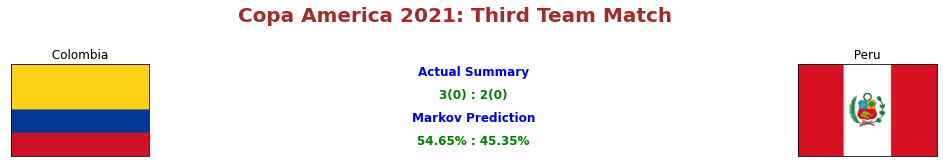

In [ ]:
Third_Team_Match = predict_3rd_team(copa2021)

fig = plt.figure(figsize=(20,20))
fig.suptitle("Copa America 2021: Third Team Match",x=0.5,y=0.92,fontsize=20,horizontalalignment='center',weight='bold', color ='Brown')
idx = 1

for k, v in Third_Team_Match.items():
  teamA, teamB = k
  oddsA, oddsB = v[0]
  scoreA, scoreB = v[1]
  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamA.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamA)
  idx+=1

  ax = fig.add_subplot(10,3,idx)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,4)
  ax.text(0.5,3.5,'Actual Summary',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,2.5,scoreA+' : '+scoreB,fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  ax.text(0.5,1.5,'Markov Prediction',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,0.5,f"{oddsA:0.2f}% : {oddsB:0.2f}%",fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  idx+=1

  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamB.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamB)
  idx+=1


### Final Match Prediction

In [ ]:
########### Predict Final by Group Stage, Quarter-finals, Semi-finals ard 3rd Team distribution ###################

def predict_final(matchdata):
  teams = list(set(list(matchdata['team_name_home'])+list(matchdata['team_name_away'])))
  goalMat = np.zeros((len(teams),len(teams)))
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']

    if not (stage.split()[0]=='Group' or stage.split()[0]=='Quarter-finals' or stage.split()[0]=='Semi-finals' ):
      continue
    
    goalMat[teams.index(away_team)][teams.index(home_team)]=home_score
    goalMat[teams.index(home_team)][teams.index(away_team)]=away_score

    if penalty_shoot:
      goalMat[teams.index(away_team)][teams.index(home_team)]+=(int(home_penalty_score)/10)
      goalMat[teams.index(home_team)][teams.index(away_team)]+=(int(away_penalty_score)/10)
  
  goalMat/=np.sum(goalMat,axis=1)[:, np.newaxis]
  mc =    pydtmc.MarkovChain(goalMat,teams)
  
  steady_states = mc.steady_states[0]

  quater_final = dict()
  for index, row in matchdata.iterrows():
    stage = row['stage']
    home_team = row['team_name_home']
    away_team = row['team_name_away']
    home_score = row['team_home_score']
    away_score = row['team_away_score']
    penalty_shoot = row['pens']
    home_penalty_score = row['pens_home_score']
    away_penalty_score = row['pens_away_score']
    if stage.split()[0] != 'Final':
      continue
    
    pHome = steady_states[teams.index(home_team)]
    pAway = steady_states[teams.index(away_team)]

    homeOdds = 100*pHome/(pHome+pAway)
    awayOdds = 100*pAway/(pHome+pAway)

    homeActual = str(home_score) + '('+(home_penalty_score if penalty_shoot else '0')+')'
    awayActual = str(away_score) + '('+(away_penalty_score if penalty_shoot else '0')+')'

    quater_final[(home_team,away_team)]=((homeOdds, awayOdds),(homeActual,awayActual))

  return quater_final

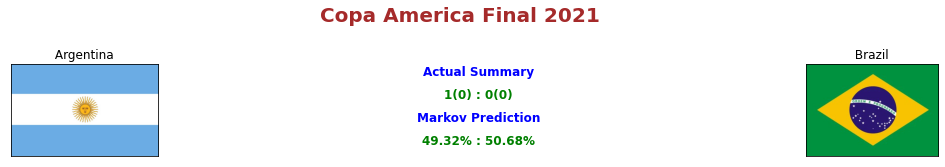

In [ ]:
Final = predict_final(copa2021)

fig = plt.figure(figsize=(20,20))
fig.suptitle("Copa America Final 2021",x=0.5,y=0.92,fontsize=20,horizontalalignment='center',weight='bold', color ='Brown')
idx = 1

for k, v in Final.items():
  teamA, teamB = k
  oddsA, oddsB = v[0]
  scoreA, scoreB = v[1]
  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamA.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamA)
  idx+=1

  ax = fig.add_subplot(10,3,idx)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,4)
  ax.text(0.5,3.5,'Actual Summary',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,2.5,scoreA+' : '+scoreB,fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  ax.text(0.5,1.5,'Markov Prediction',fontsize=12,horizontalalignment='center',weight='bold',color ='Blue')
  ax.text(0.5,0.5,f"{oddsA:0.2f}% : {oddsB:0.2f}%",fontsize=12,horizontalalignment='center',weight='bold',color ='Green')
  idx+=1

  fig.add_subplot(10,3,idx,xticks=[],yticks=[])
  img = Image.open('/content/Flags/'+teamB.lstrip()+'.jpg')
  plt.imshow(img)
  plt.title(teamB)
  idx+=1
